# Sprint: Data Visualization with Python
## Coursera Course Dataset Analysis

### Table of Contents
1. [Introduction](#introduction)
2. [Data Import](#data-import)
3. [Data Cleaning](#data-cleaning)
4. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)

*P.S. Clickable ToC function works in Jupiter notebook environment.*

*P.P.S. To be able to interact with Plotly generated plots and see hover labels, make sure to download the notebook.*

<a id="introduction"></a>

---

### Introduction

**Goal of this analysis**  is to provide useful insight to Coursera organization on how to increase student enrolment numbers. In order to do that, I will explore several research questions:
- Do organizations which offer more education products on Coursera attract more students? 
- How do Coursera offerings ratings correlate with the number of students enrolled?
- What are the enrollment patterns associated with different certificate types?
- How does course difficulty relate to the number of students enrolled?

### Data Import
Importing all needed libraries for analysis and visualization. Also, making sure that plots are displayed inline and work with Jupiter notebook format. Plotly interactive plots do not get displayed on Github, was adding svg file formate to be used as an alternative one for them. For context, this notebook as created in VS Code environment. 

In [89]:
import pandas as pd
import numpy as np
from rapidfuzz import fuzz
import kaleido as kld
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
cf.go_offline()
import plotly.io as pio
pio.renderers.default = "vscode+svg"


Next, importing data and seeing preview of it. 

In [90]:
df = pd.read_csv("coursea_data.csv", index_col=0)
df.sort_index(inplace=True)
df.head()

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
0,IBM Data Science,IBM,PROFESSIONAL CERTIFICATE,4.6,Beginner,480k
1,Introduction to Data Science,IBM,SPECIALIZATION,4.6,Beginner,310k
2,The Science of Well-Being,Yale University,COURSE,4.9,Mixed,2.5m
3,Python for Everybody,University of Michigan,SPECIALIZATION,4.8,Beginner,1.5m
4,Google IT Support,Google,PROFESSIONAL CERTIFICATE,4.8,Beginner,350k


In [91]:
df.shape

(891, 6)

### Data cleaning

#### Data types
First, need to fix incorrect data types. 

In [92]:
df.dtypes

course_title                 object
course_organization          object
course_Certificate_type      object
course_rating               float64
course_difficulty            object
course_students_enrolled     object
dtype: object

String data is set to object type. Will convert it to categorical pandas extension type. It's good practice for performance improvement.  
Also, column "course_students_enrolled" should be numeric but is object type right now due to having "k" and "m" values instead of zeros. Need to make it numeric instead. 

In [93]:
category_columns = ["course_title", "course_organization", "course_Certificate_type", "course_difficulty"]
df[category_columns] = df[category_columns].astype('category')
values = df["course_students_enrolled"].str[-1]
values.unique()

array(['k', 'm'], dtype=object)

In [94]:
df["course_students_enrolled"] = df["course_students_enrolled"].apply(lambda value: int(float(value[:-1])*1000) if value.endswith("k") else int(float(value[:-1])*1000000))

In [95]:
df.head(3)

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
0,IBM Data Science,IBM,PROFESSIONAL CERTIFICATE,4.6,Beginner,480000
1,Introduction to Data Science,IBM,SPECIALIZATION,4.6,Beginner,310000
2,The Science of Well-Being,Yale University,COURSE,4.9,Mixed,2500000


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   course_title              891 non-null    category
 1   course_organization       891 non-null    category
 2   course_Certificate_type   891 non-null    category
 3   course_rating             891 non-null    float64 
 4   course_difficulty         891 non-null    category
 5   course_students_enrolled  891 non-null    int64   
dtypes: category(4), float64(1), int64(1)
memory usage: 70.9 KB


#### Missing values
From above it's visible that that there are no nulls. Just in case, can check again using this code.

In [97]:
df.isnull().any().any()

np.False_

Seems there are none. 
#### Duplicates
First, need to check general overview of the data. Will need to redo type casting because str functions change output back to object type.

In [98]:
df = df.apply(lambda x: x.str.lower().str.strip() if x.dtype == "category" else x)
df[category_columns] = df[category_columns].astype('category')
df.describe(include="all")

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
count,891,891,891,891.000000,891,8.910000e+02
unique,888,154,3,NaN,4,NaN
top,developing your musicianship,university of pennsylvania,course,NaN,beginner,NaN
freq,2,59,582,NaN,487,NaN
mean,NaN,NaN,NaN,4.677329,NaN,9.055208e+04
std,NaN,NaN,NaN,0.162225,NaN,1.819365e+05
min,NaN,NaN,NaN,3.300000,NaN,1.500000e+03
25%,NaN,NaN,NaN,4.600000,NaN,1.750000e+04
50%,NaN,NaN,NaN,4.700000,NaN,4.200000e+04
75%,NaN,NaN,NaN,4.800000,NaN,9.950000e+04


It's visible, that almost all course titles are unique, but not all. Need to check which and why.

In [99]:
titles = df["course_title"].value_counts()
titles = titles[titles > 1] 
titles = titles.index.tolist()
df[df["course_title"].isin(titles)].sort_values(by="course_title")

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
205,developing your musicianship,berklee college of music,specialization,4.8,beginner,54000
756,developing your musicianship,berklee college of music,course,4.8,mixed,41000
6,machine learning,stanford university,course,4.9,mixed,3200000
181,machine learning,university of washington,specialization,4.6,intermediate,290000
241,marketing digital,universidade de são paulo,course,4.8,beginner,81000
325,marketing digital,universidad austral,specialization,4.7,beginner,39000


It's visible that some offerings from different organizations have just generic repeatable titles, thus are not duplicates, just called the same way. When it comes to "developing your musicianship" course from "berklee college of music", it's a different case. I went to [Coursera site](https://www.coursera.org/learn/develop-your-musicianship?specialization=musicianship-specialization) to check this data. Turns out this course is part of "Developing Your Musicianship Specialization", thus they course and specialization share the same name. 

Thus, there are no duplicate values.

#### Inconsistent Data Entry

Need to check for inconsistent definitions of values if any are left. For this, checking unique values count.

In [100]:
df["course_difficulty"].value_counts()

course_difficulty
beginner        487
intermediate    198
mixed           187
advanced         19
Name: count, dtype: int64

In [101]:
df["course_Certificate_type"].value_counts()

course_Certificate_type
course                      582
specialization              297
professional certificate     12
Name: count, dtype: int64

All few unique values available are indeed distinct. 

For columns with they more unique values, will I used fuzz ratio calculation to help identify any similar ones. To start with I picked 90. 

First - "course_title".

In [102]:
course_title_matches = []

course_title_values = df["course_title"].unique()

for first in range(len(course_title_values)):
    for second in range(first+1, len(course_title_values)):
        value1 = course_title_values[first]
        value2 = course_title_values[second]
        similarity_ratio = fuzz.ratio(value1, value2)

        if similarity_ratio > 90:
            course_title_matches.append({
                'Value 1': value1,
                'Value 2': value2,
                'Similarity': similarity_ratio
            })

course_title_matches = pd.DataFrame(course_title_matches).sort_values(by='Similarity', ascending=False).reset_index(drop=True)
pd.set_option('display.max_colwidth', None)
course_title_matches

,Value 1,Value 2,Similarity
0,excel skills for business: intermediate i,excel skills for business: intermediate ii,98.795181
1,the power of macroeconomics: economic principles in the real world,the power of microeconomics: economic principles in the real world,98.484848
2,"tesol certificate, part 1: teach english now!","tesol certificate, part 2: teach english now!",97.777778
3,developing applications with google cloud platform,developing applications with google cloud platform 日本語版,95.238095
4,introduction to financial accounting,more introduction to financial accounting,93.506494
5,mathematics for machine learning,mathematics for machine learning: pca,92.753623
6,machine learning with tensorflow on google cloud platform,advanced machine learning with tensorflow on google cloud platform,92.682927
7,introduction to web development,introduction to game development,92.063492
8,excel/vba for creative problem solving,"excel/vba for creative problem solving, part 1",90.476190
9,fundamentals of computing,fundamentals of accounting,90.196078


After checking these values, they appear to be similar namings for courses of same specialization. Thus, no inconsistent data entries were found. 

Next - "course_organization".

In [103]:
course_organization_matches = []

course_organization_values = df["course_organization"].unique()

for first in range(len(course_organization_values)):
    for second in range(first+1, len(course_organization_values)):
        value1 = course_organization_values[first]
        value2 = course_organization_values[second]
        similarity_ratio = fuzz.ratio(value1, value2)  

        if similarity_ratio > 90:
            course_organization_matches.append({
                'Value 1': value1,
                'Value 2': value2,
                'Similarity': similarity_ratio
            })

course_organization_matches = pd.DataFrame(course_organization_matches).sort_values(by='Similarity', ascending=False).reset_index(drop=True)
pd.set_option('display.max_colwidth', None)
course_organization_matches

,Value 1,Value 2,Similarity
0,ie business school,iese business school,94.736842
1,essec business school,iese business school,92.682927
2,essec business school,escp business school,92.682927
3,edhec business school,essec business school,90.476190


After checking on Coursera, these are indeed different business schools. Thus, no inconsistent data entries were found. 

Will apply title formatting back for future visualizations. It will change to object type again, so have to recast to category one. 

In [104]:
df = df.apply(lambda x: x.str.title() if x.dtype == "category" else x)
df[category_columns] = df[category_columns].astype('category')

#### Outliers
Will check what kind of outliers are in numerical columns. To have broader overview, will segment based on certification type and it's difficulty. 
##### Sudents enrolled

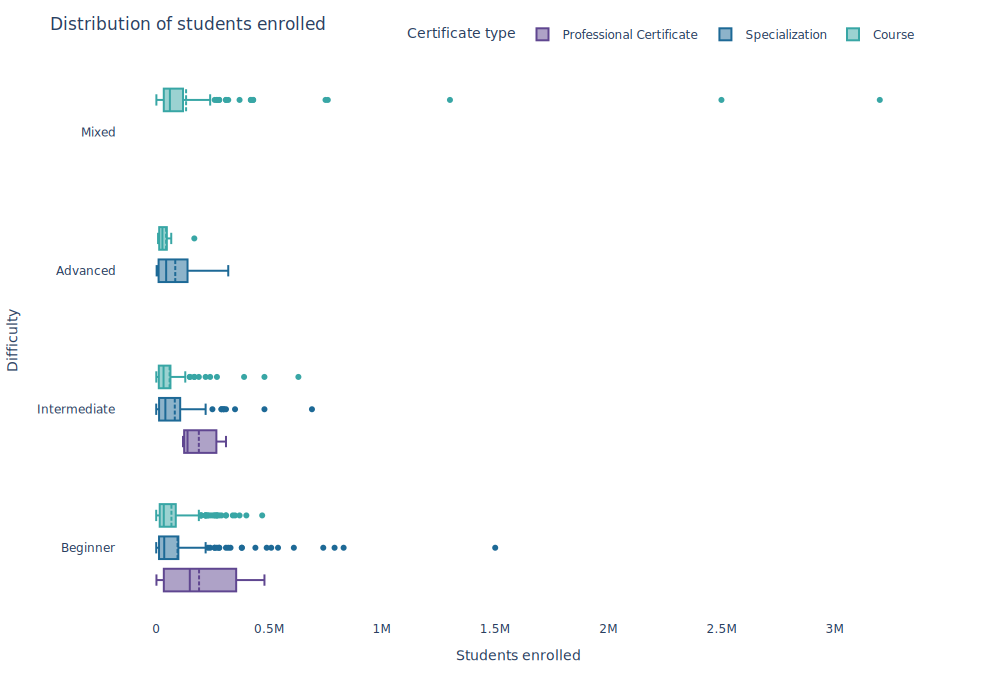

In [105]:
fig = px.box(
    df, 
    y = "course_difficulty", 
    x="course_students_enrolled", 
    color = "course_Certificate_type", 
    custom_data=["course_title", "course_rating", "course_organization"], 
    width=1000, 
    height=700,
    color_discrete_sequence=px.colors.qualitative.Prism
)

fig.update_layout(
    title = "Distribution of students enrolled",
    xaxis_title = "Students enrolled",
    yaxis_title = "Difficulty",
    legend_title = "Certificate type",
    plot_bgcolor= "white",
    hoverlabel=dict(
        bgcolor="white",
        bordercolor = "white",
        font=dict(
            color="#494a5e"
        )
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)  
       
fig.update_traces(
    hovertemplate="Title: <b>%{customdata[0]}</b><br>" +
                  "Students Enrolled: %{x:,.0f}<br>" +
                  "Organization: %{customdata[2]}<br>" +
                  "Rating: %{customdata[1]}<br>",
    boxmean=True
)
  
fig.show()

Can see that certain courses have really high enrolment numbers. To verify this is correct, I looked up their current status on Coursera. For example, ["The Science Of Well-Being"](https://www.coursera.org/learn/the-science-of-well-being#modules) mixed difficulty course has now above 4 million enrollments even. Thus, keeping it and cleanliness of the data so far these values seem to be correct. 

Since these values even if valid, are quite extreme it will affect the analysis. Due to that, I will analyze them separately from the main smaller value ones. For that, since this is not normal distributed data, I will use inner quartile range to identify and separate them. Also, will calculate outlier student ratio (how many were removed by removing these outliers). 

In [106]:
Q1 = df["course_students_enrolled"].quantile(0.25)
Q3 = df["course_students_enrolled"].quantile(0.75)
IQR = Q3 - Q1
threshold = 1.5

outliers_enrollment = df[(df["course_students_enrolled"] < (Q1 - threshold * IQR)) | (df["course_students_enrolled"] > (Q3 + threshold * IQR))]
outliers_enrollment_total_students = outliers_enrollment["course_students_enrolled"].sum()
outliers_enrollment.shape

(78, 6)

##### Ratings

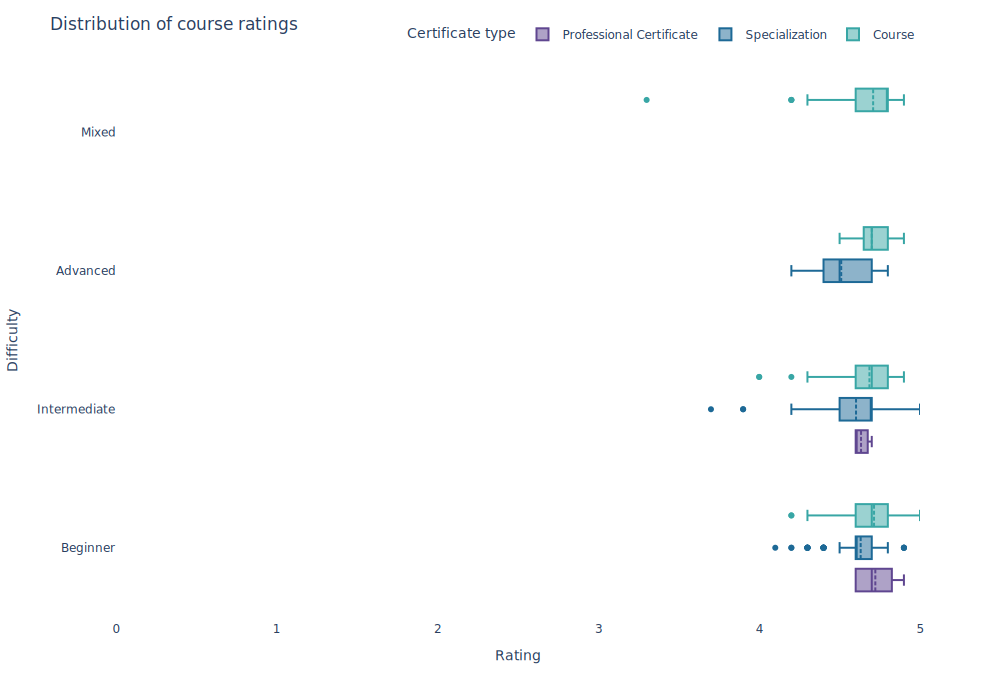

In [107]:
fig = px.box(
    df, 
    y = "course_difficulty", 
    x="course_rating", 
    color = "course_Certificate_type", 
    custom_data=["course_title", "course_students_enrolled", "course_organization"],
    width=1000, 
    height=700,
    color_discrete_sequence=px.colors.qualitative.Prism
)

fig.update_layout(
    title = "Distribution of course ratings",
    xaxis=dict(
        title="Rating",
        range=[0, 5] 
    ),
    yaxis_title = "Difficulty",
    legend_title = "Certificate type",
    plot_bgcolor= "white",
    hoverlabel=dict(
        bgcolor="white",
        bordercolor = "white",
        font=dict(
            color="#494a5e"
        )
    ),
    legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
    )
)   
      
fig.update_traces(
    hovertemplate="Title: <b>%{customdata[0]}</b><br>" + 
                "Students Enrolled: %{customdata[1]:,.0f}<br>" +
                  "Organization: %{customdata[2]}<br>" +
                  "Rating: %{x}<br>",
    boxmean=True
)

fig.show()

Most offerings have higher than 4 stars ratings. I checked couple which have way lower ones like ["How To Create A Website In A Weekend! (Project-Centered Course)"](https://www.coursera.org/learn/how-to-create-a-website) and ratings are indeed correct to be this low. Since there is only a few of them with relatively close values, I will not separate them. Leaving them should not skew results.

Now we can see ratio of students excluded by removing these outliers. 

In [108]:
df_total_students = df["course_students_enrolled"].sum()
df_total_students
outlier_student_ratio = ((outliers_enrollment_total_students / df_total_students) * 100).round(2)
print(f"Students excluded: {outlier_student_ratio}%")

Students excluded: 44.43%


This number is very high, almost half of student population. Thus, should not be omitted from analysis, just will be analyzed separately. 

Now, will make separate version of dataset without them to be used for analysis of less popular educational products. Since data will be removed, need to remove unused_categories as well, otherwise it can affect analysis. 

In [109]:
df_cleaned = df[~df.index.isin(outliers_enrollment.index)]
df_cleaned[category_columns] = df_cleaned[category_columns].apply(lambda col: col.cat.remove_unused_categories())
outliers_enrollment[category_columns] = outliers_enrollment[category_columns].apply(lambda col: col.cat.remove_unused_categories())
df_cleaned.shape

(813, 6)

### Exploratory Data Analysis (EDA)

#### Note on correlation

Method chosen was Pearson correlation, because of comparison of values, not ranks. Also, it can be done mainly only if data is normal distributed. In this case that's not fully correct. However, since it's needed to calculate a correlation coefficient, not to it's it's statistical significance, it is okay to be used.

Correlation coefficient interpretations divides results usually into 4 or 5 parts. I chose [5 parts](https://resources.nu.edu/statsresources/correlation) scale:
  -  -1 = perfect negative correlation
  -  -0.7 = strong negative correlation
  -  -0.5 = moderate negative correlation
  -  -0.3 = weak negative correlation
  -  0 = no correlation
  -  0.3 = weak positive correlation
  -  0.5 = moderate positive correlation
  -  0.7 = strong positive correlation
  -  1 = perfect positive correlation

#### Do organizations which offer more education products on Coursera attract more students? 


First, I checked number of offerings per organization. 

In [140]:
df_grouped_per_organization = df_cleaned["course_students_enrolled"].groupby(df_cleaned["course_organization"], observed=True).agg(["mean", "count"]).reset_index()
print(f"Total number of organizations: {df_grouped_per_organization.shape[0]}.")

Total number of organizations: 153.


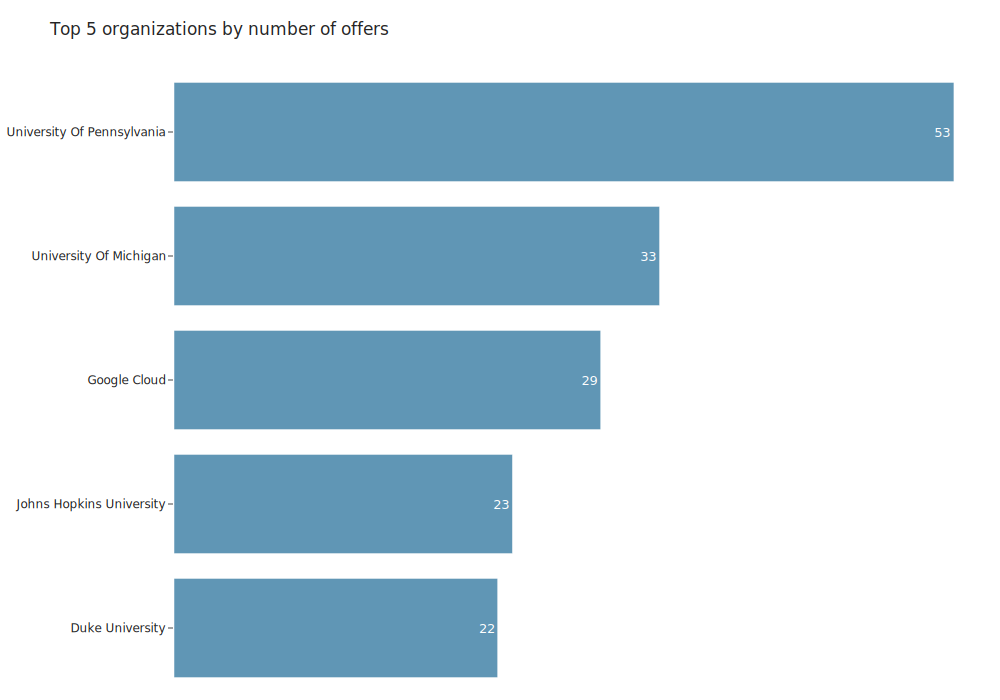

In [196]:
top_5_df_grouped_per_organization = df_grouped_per_organization.sort_values(by = "count", ascending=False).head(5).sort_values(by = "count", ascending=True)

fig = go.Figure(go.Bar( 
    x = top_5_df_grouped_per_organization["count"], 
    y = top_5_df_grouped_per_organization["course_organization"], 
    orientation="h",
    customdata=top_5_df_grouped_per_organization[['mean']],
    marker_color = px.colors.qualitative.Prism[1],
    opacity=0.7
    )
)

fig.update_layout(
    title="Top 5 organizations by number of offers",
    template="simple_white",
    height=700,
    width=1000,
    xaxis=dict(
        visible=False, 
        showticklabels=False 
    ),
    yaxis=dict(
        showline=False, 
        showticklabels=True,  
             
    ),
    margin=dict(b = 10, t = 70, r = 5),
        hoverlabel=dict(
        bgcolor="white",
        bordercolor = "white",
        font=dict(
            color="#494a5e"
        )
    )
)

fig.update_traces(
    text=top_5_df_grouped_per_organization["count"],
    texttemplate='%{text}', 
    textfont=dict(size=13),
    name=""
)

fig.update_traces(
    hovertemplate=
    "Organization: <b>%{y}</b><br>" +
    "Number of products: %{x}<br>" + 
    "AVG number of students per course: %{customdata[0]:,.0f}" 
)

fig.show()

We can see that top 5 organizations by offerings count are 4 universities and 1 company - Google. Also, it's visible that having more courses does not mean having more students on average in the top 5 case. Below we will see if it's true with the rest of the data. 

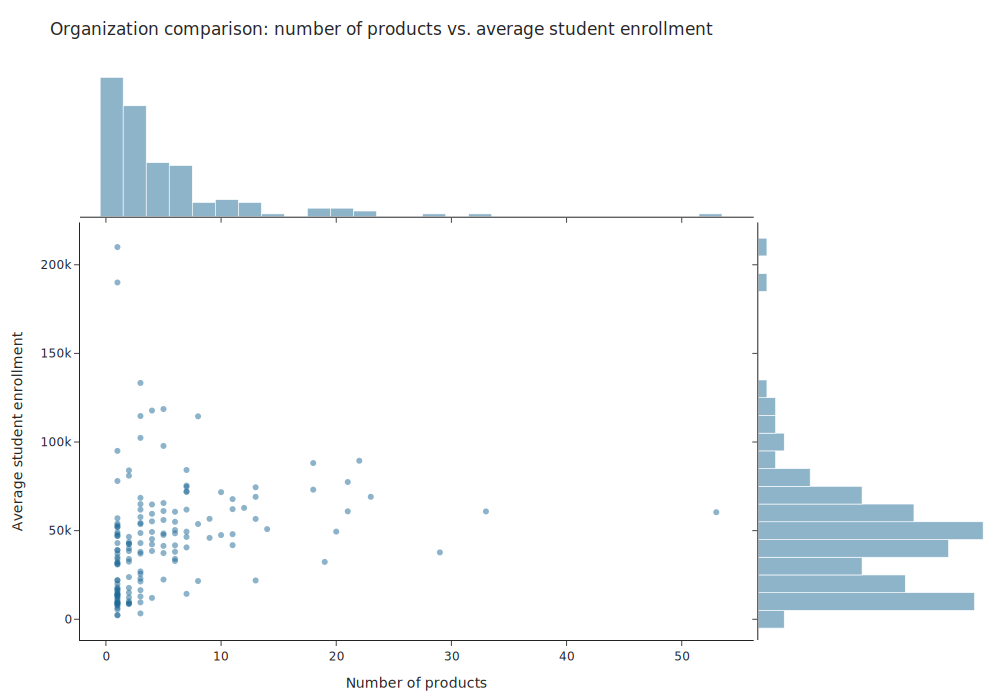

In [198]:
fig = px.scatter(
    df_grouped_per_organization, 
    x = "count", 
    y = "mean", 
    marginal_x="histogram", 
    marginal_y="histogram", 
    template="simple_white",
    height=700,
    width=1000,
    custom_data = "course_organization",
    color_discrete_sequence = [px.colors.qualitative.Prism[1]],
    title="Organization comparison: number of products vs. average student enrollment",
    labels={
        "count": "Number of products",
        "mean": "Average student enrollment"
    }
)

fig.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        bordercolor = "white",
        font=dict(
            color="#494a5e"
        )
    ),
    margin=dict(r = 5, t = 70, b = 60)
)

fig.update_traces(
    marker=dict(
        color="#1D6996", 
        opacity=0.5),
    selector=dict(
        type="scatter"),
    hovertemplate=
    "Organization: <b>%{customdata[0]}</b><br>" +
    "Number of products: %{x}<br>" + 
    "AVG number of students per course: %{y:,.0f}" 
)

fig.show()

In [114]:
correlation = df_grouped_per_organization["count"].corr(df_grouped_per_organization["mean"]).round(2)
print(f"The correlation coefficient is: {correlation}.")

The correlation coefficient is: 0.22.


In literature up to 0.3 is considered weak positive correlation. Thus, correlation between average number of students enrolled and number of offerings per organization is week positive one. This indicates that focusing on this most likely would not be very effective to increase student enrolment. 

**What about outliers?**

In [115]:
outliers_enrollment_grouped_per_organization = outliers_enrollment["course_students_enrolled"].groupby(outliers_enrollment["course_organization"], observed=True).agg(["mean", "count"]).reset_index()
print(f"Total number of organizations: {outliers_enrollment_grouped_per_organization.shape[0]}.")

Total number of organizations: 31.


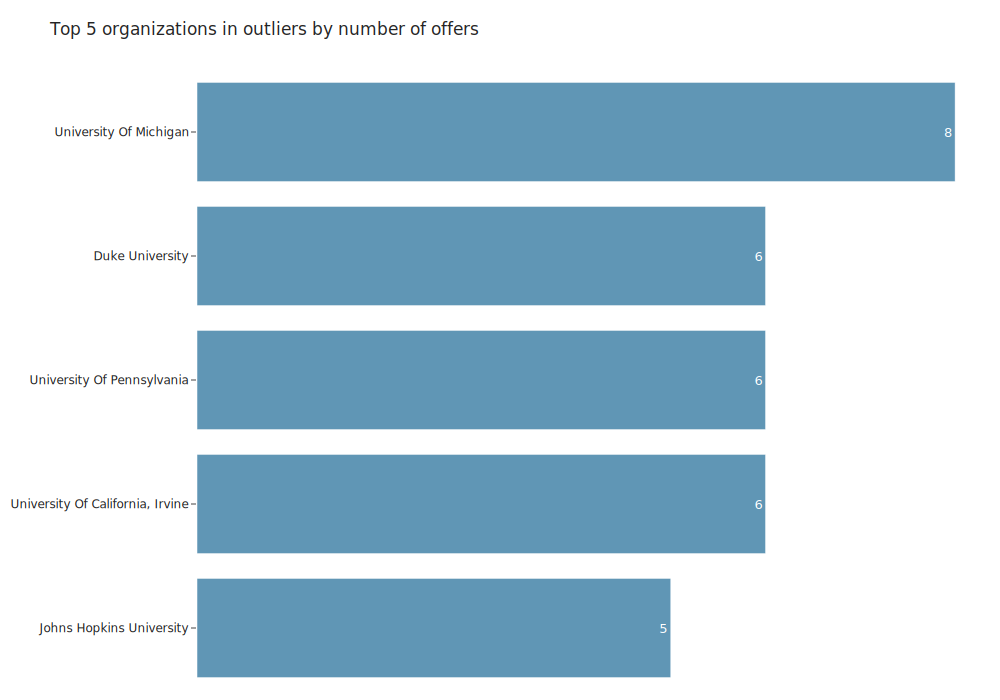

In [207]:
top_5_outliers_enrollment_grouped_per_organization = outliers_enrollment_grouped_per_organization.sort_values(by = "count", ascending=False).head(5).sort_values(by = "count", ascending=True)

fig = go.Figure(go.Bar( 
    x = top_5_outliers_enrollment_grouped_per_organization["count"], 
    y = top_5_outliers_enrollment_grouped_per_organization["course_organization"], 
    orientation="h",
    customdata=top_5_outliers_enrollment_grouped_per_organization[["mean"]],
    marker_color = px.colors.qualitative.Prism[1],
    opacity=0.7
    )
)

fig.update_layout(
    title="Top 5 organizations in outliers by number of offers",
    template="simple_white",
    height=700,
    width=1000,
    xaxis=dict(
        visible=False, 
        showticklabels=False 
    ),
    yaxis=dict(
        showline=False, 
        showticklabels=True,  
             
    ),
    margin=dict(b = 10, t = 70, r = 5),
        hoverlabel=dict(
        bgcolor="white",
        bordercolor = "white",
        font=dict(
            color="#494a5e"
        )
    )
)

fig.update_traces(
    text=top_5_outliers_enrollment_grouped_per_organization["count"],
    texttemplate='%{text}', 
    textfont=dict(size=13),
    name=""
)

fig.update_traces(
    hovertemplate=
    "Organization: <b>%{y}</b><br>" +
    "Number of products: %{x}<br>" + 
    "AVG number of students per course: %{customdata[0]:,.0f}" 
)

fig.show()

In outliers data set, organizations do not have that many products in Coursera. However, average enrolment is way higher. From around 60,000 in regular data set to above 300,000 in outliers. 

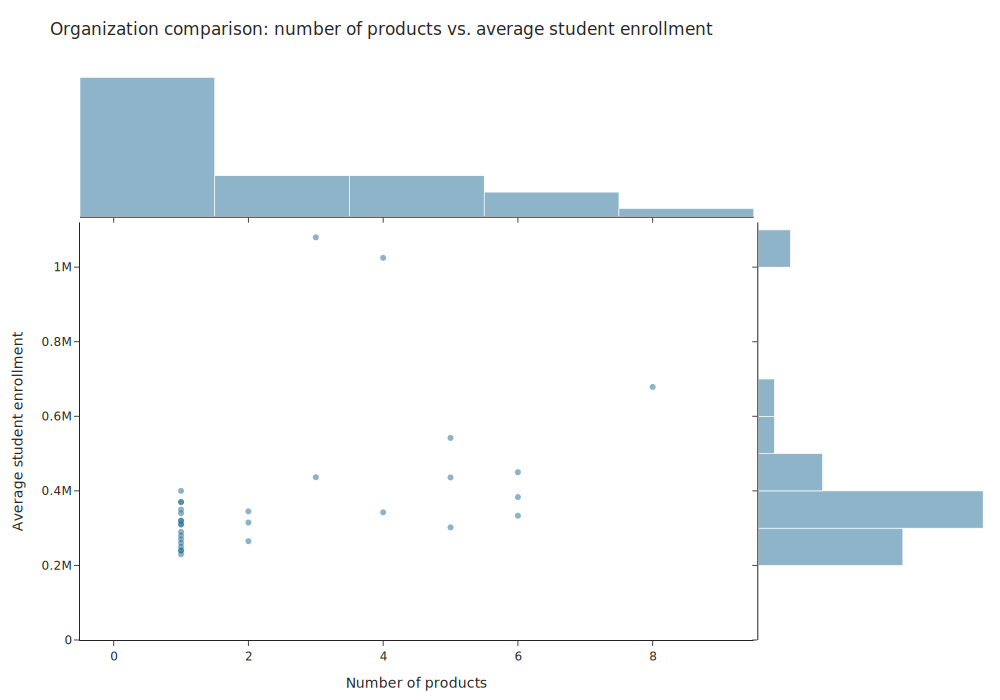

In [199]:
fig = px.scatter(
    outliers_enrollment_grouped_per_organization, 
    x = "count", 
    y = "mean", 
    marginal_x="histogram", 
    marginal_y="histogram", 
    template="simple_white",
    height=700,
    width=1000,
    custom_data = "course_organization",
    color_discrete_sequence = [px.colors.qualitative.Prism[1]],
    title="Organization comparison: number of products vs. average student enrollment",
    labels={
        "count": "Number of products",
        "mean": "Average student enrollment"
    }
)

fig.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        bordercolor = "white",
        font=dict(
            color="#494a5e"
        )
    ),
    margin=dict(r = 5, t = 70, b = 60),
    yaxis=dict(
        range=
        [0, 
         outliers_enrollment_grouped_per_organization['mean'].max()+40000]
    ),
)

fig.update_traces(
    marker=dict(color="#1D6996", opacity=0.5),
    selector=dict(type="scatter"),
    hovertemplate=
    "Organization: <b>%{customdata[0]}</b><br>" +
    "Number of products: %{x}<br>" + 
    "AVG number of students per course: %{y:,.0f}" 
)

fig.show()

In [117]:
correlation = outliers_enrollment_grouped_per_organization["count"].corr(outliers_enrollment_grouped_per_organization["mean"]).round(2)
print(f"The correlation coefficient is: {correlation}.")

The correlation coefficient is: 0.44.


There are around 5 times less organizations in outliers dataset (31). Average number of offers on Coursera varies quite a lot here, from around 200,000 to 1,000,000.  

However, from chart it's visible that top 5 are actually all universities. Also, if we look at highest enrolment averages, they are from universities as well. After quick google search, we can see that these ones are one of the top ranking ones. For example, Yale is #5 in [national rankings](https://www.usnews.com/best-colleges/yale-university-1426/overall-rankings). 

Also, correlation here is a little bit higher (0.44), closer to moderate positive one. 

#### How do Coursera offerings ratings correlate with the number of students enrolled?

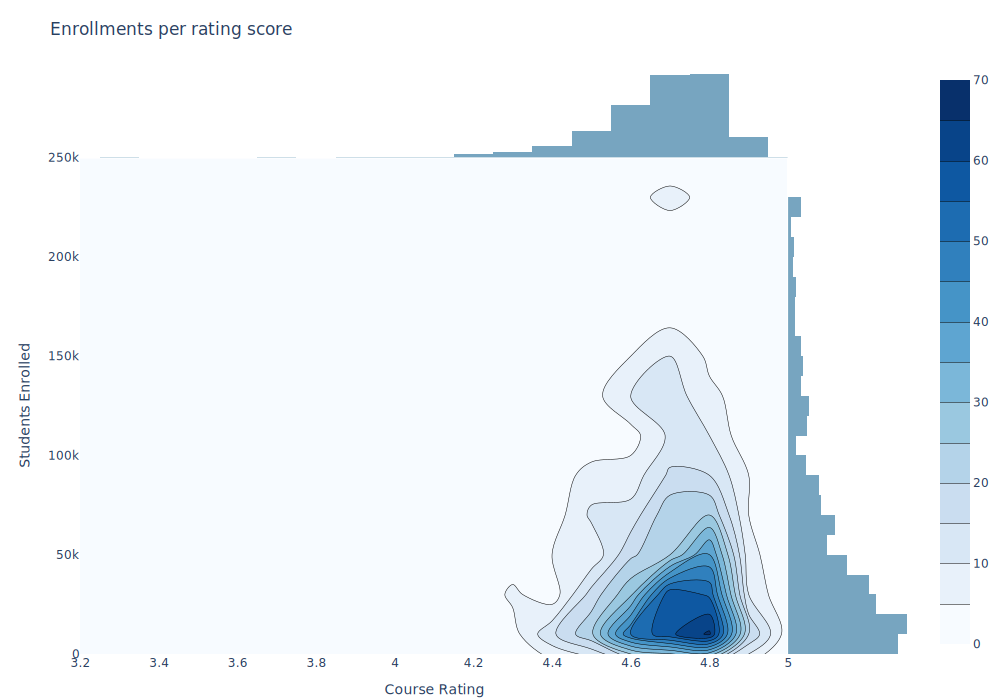

In [119]:
fig = go.Figure(go.Histogram2dContour(
    x=df_cleaned["course_rating"],
    y=df_cleaned["course_students_enrolled"],
    colorscale="Blues", 
    contours=dict(
        coloring="fill",
    ),
    name="",
    zmin=0,
    zmax=70,
        hovertemplate=
        "Students Enrolled: %{y:,.0f}<br>" + 
        "Rating: %{x}<br>" + 
        "Density: %{z}<br>"
))

fig.update_layout(
    title="Enrollments per rating score",
    xaxis_title="Course Rating",
    yaxis_title="Students Enrolled",
    width=1000,
    height=700,
    margin=dict(t=70, b=5),
    plot_bgcolor="white",
    hoverlabel=dict(
        bgcolor="white",
        bordercolor = "white",
        font=dict(
            color="#494a5e"
        )
    )
)

fig.add_trace(go.Histogram(
    y = df_cleaned["course_students_enrolled"],
    xaxis = "x2",
    marker = dict(
        color="#1D6996"
    ),
    showlegend=False,
    opacity=0.6,
    hovertemplate=(
        "Students Enrolled: %{y:,.0f}<br>" +
        "Count: %{x}<br>"
    ),
    name=""
))


fig.add_trace(go.Histogram(
    x = df_cleaned["course_rating"],
    yaxis = "y2",
    marker = dict(
        color = "#1D6996",
    ),
    showlegend=False,
    opacity=0.6,
    hovertemplate=(
        "Rating: %{x}<br>" +
        "Count: %{y}<br>" 
    ),
    name=""
))

fig.update_layout(
    xaxis = dict(
        domain = [0,0.85],
        showgrid = False,
        range=[3.2,5]
    ),
    yaxis = dict(
        domain = [0,0.85],
        showgrid = False,
        range=[0,250000]
    ),
    xaxis2 = dict(
        domain = [0.85,1],
        showticklabels=False
    ),
    yaxis2 = dict(
        domain = [0.85,1],
        showticklabels=False
    )
)

fig.show()

In [120]:
correlation = df_cleaned["course_rating"].corr(df_cleaned["course_students_enrolled"]).round(2)
print(f"The correlation coefficient is: {correlation}.")

The correlation coefficient is: 0.02.


It's visible most programs have bellow 50,000 students enrolled. Also, their ratings vary but most are between 4.6 and 4.8. In that range, most programs are with lower number of students. There are a couple with higher numbers, but not many. 

When calculating Pearson correlation for it, it's also very weak positive one of 0.02. 

Since on scale from 1 to 5 most offerings are already rated very positively, above 4, it's seems reasonable that small changes to programs score do not have a big effect.

**What about outliers?**

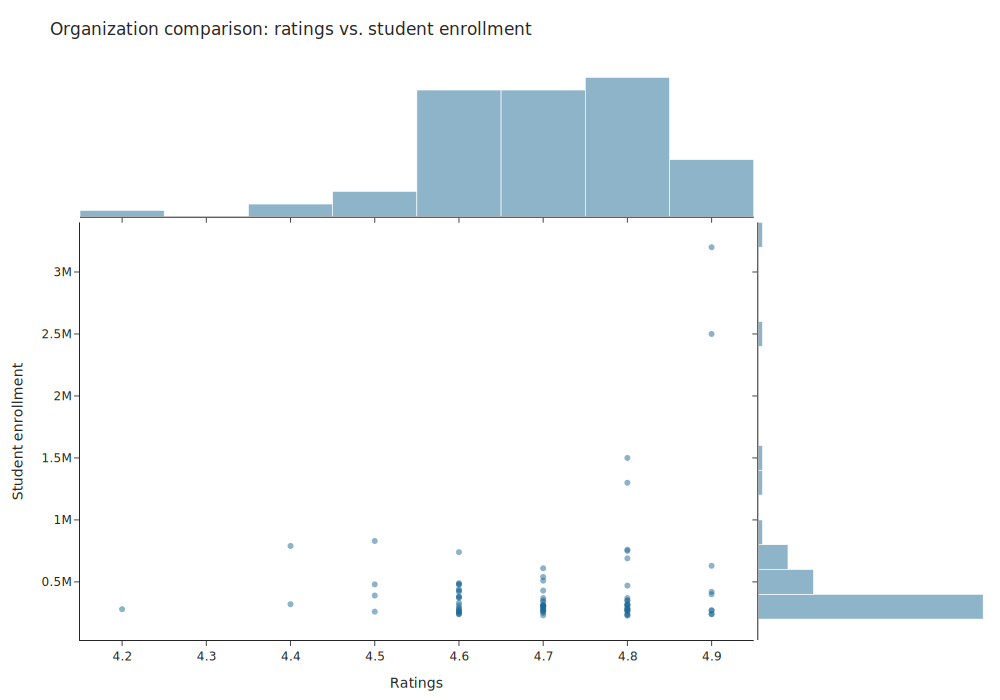

In [200]:
fig = px.scatter(
    outliers_enrollment, 
    x = "course_rating", 
    y = "course_students_enrolled", 
    marginal_x="histogram", 
    marginal_y="histogram", 
    template="simple_white",
    height=700,
    width=1000,
    custom_data = "course_organization",
    color_discrete_sequence = [px.colors.qualitative.Prism[1]],
    title="Organization comparison: ratings vs.  student enrollment",
    labels={
        "course_rating": "Ratings",
        "course_students_enrolled": "Student enrollment"
    }
)

fig.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        bordercolor = "white",
        font=dict(
            color="#494a5e"
        )
    ),
    margin=dict(r = 5, t = 70, b = 60),
    )


fig.update_traces(
    marker=dict(color="#1D6996", opacity=0.5),
    selector=dict(type="scatter"),
    hovertemplate=
    "Organization: <b>%{customdata[0]}</b><br>" +
    "Rating: %{x}<br>" + 
    "Students enrolment: %{y:,.0f}" 
)

fig.show()

#### What are the enrollment patterns associated with different certificate types?

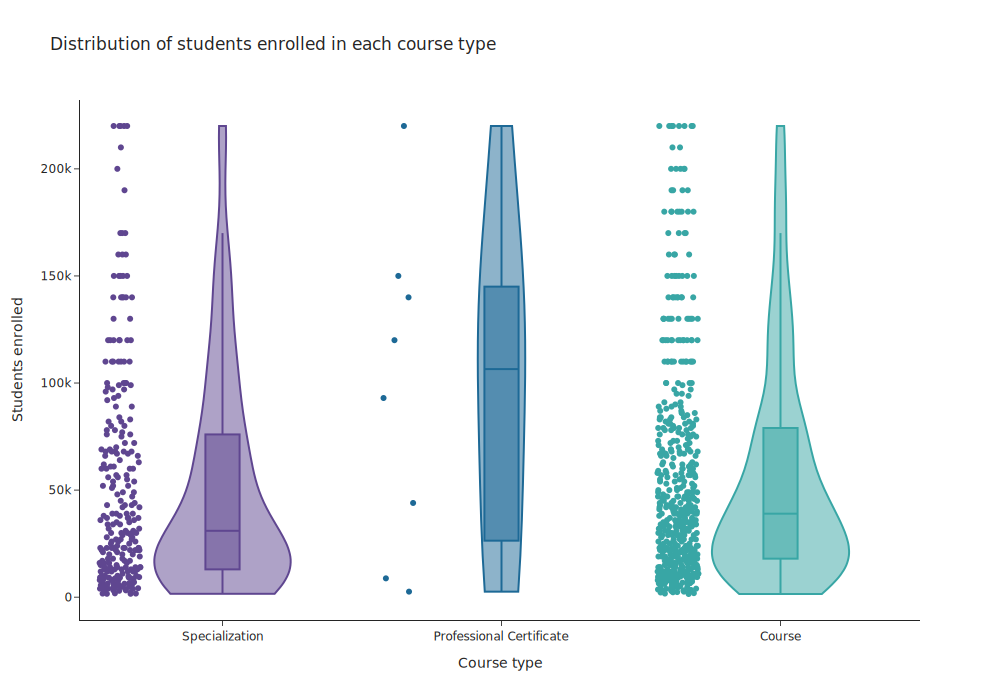

In [122]:
fig = px.violin(
    df_cleaned, 
    x = "course_Certificate_type", 
    y = "course_students_enrolled",
    template="simple_white",
    width=1000, 
    height=700,
    custom_data=["course_title", "course_students_enrolled", "course_organization", "course_rating"],
    color_discrete_sequence=px.colors.qualitative.Prism,
    points='all',
    box=True,
    color="course_Certificate_type",
    title="Distribution of students enrolled in each course type",
    labels={
        "course_Certificate_type": "Course type",
        "course_students_enrolled": "Students enrolled"
    },
    hover_data=["course_title", "course_students_enrolled"],
    hover_name="course_title",
)

fig.update_traces(
    spanmode='hard',
    showlegend = False,
    selector=dict(type='violin')
)

fig.show()

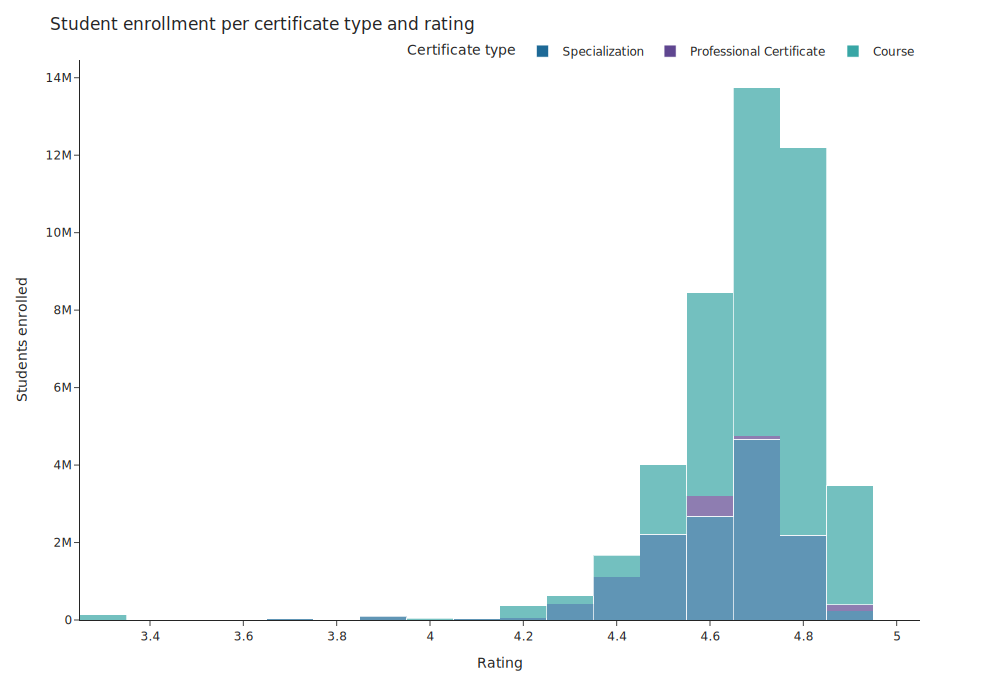

In [201]:
custom_colors = [px.colors.qualitative.Prism[1], px.colors.qualitative.Prism[0], px.colors.qualitative.Prism[2]]

fig = px.histogram(
    df_cleaned, 
    x="course_rating", 
    y="course_students_enrolled", 
    color="course_Certificate_type",
    template="simple_white",
    barmode='stack',
    width=1000, 
    height=700,
    color_discrete_sequence=custom_colors,
    opacity=0.7
)

fig.update_layout(
    title = "Student enrollment per certificate type and rating",
    xaxis_title = "Rating",
    yaxis_title = "Students enrolled",
    legend_title = "Certificate type",
    plot_bgcolor= "white",
    hoverlabel=dict(
        bgcolor="white",
        bordercolor = "white",
        font=dict(
            color="#494a5e"
        )
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=0.99,
        xanchor="right",
        x=1
    )
)  


fig.update_traces(
    hovertemplate=
                "Students Enrolled: %{y:,.0f}<br>" +
                  "Rating: %{x}<br>"
)

fig.show()

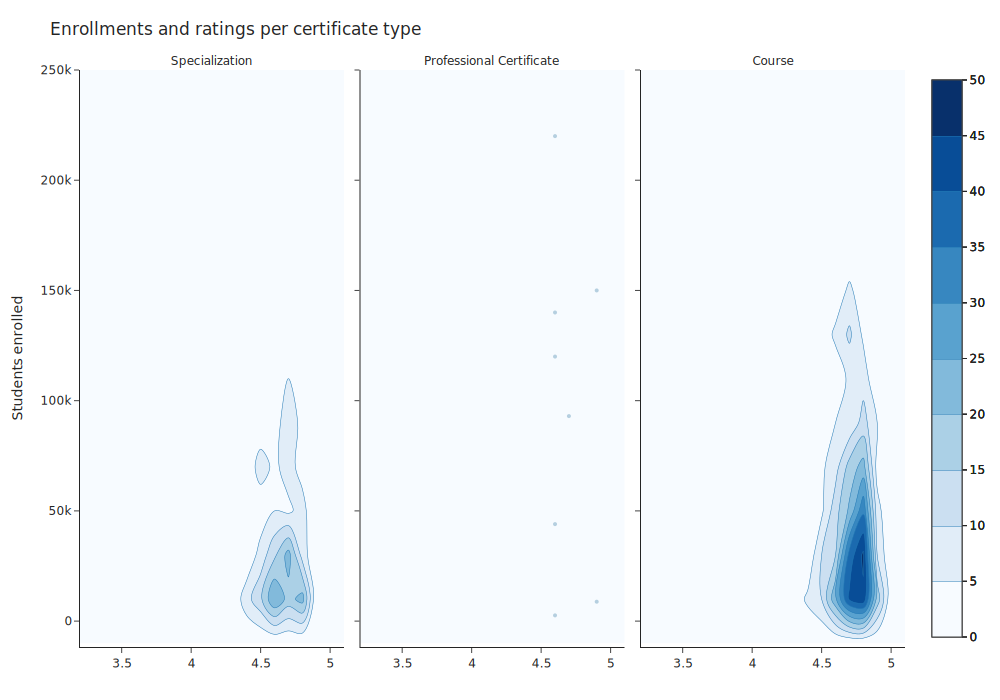

In [124]:
fig = px.density_contour(
    df_cleaned, 
    x="course_rating", 
    y="course_students_enrolled", 
    facet_col="course_Certificate_type", 
    template="simple_white",
    width=1000, 
    height=700
)

fig.update_traces(
    contours_coloring="fill", 
    colorscale="Blues",
    zmin=0,
    zmax=50,
    hovertemplate=
        "Students Enrolled: %{y:,.0f}<br>" + 
        "Rating: %{x}<br>" + 
        "Density: %{z}<br>" 
)

fig.update_layout(
    title = "Enrollments and ratings per certificate type",
    yaxis_title = "Students enrolled",
    hoverlabel=dict(
        bgcolor="white",
        bordercolor = "white",
        font=dict(
            color="#494a5e"
        )
    ),
    margin=dict(t=70, b=5)
)

second_facet_data = df_cleaned[df_cleaned['course_Certificate_type'] == "Professional Certificate"]
fig.add_trace(go.Scatter(
    x=second_facet_data['course_rating'],
    y=second_facet_data['course_students_enrolled'],
    mode='markers',
    marker=dict(
        color="#1D6996",
        size=4,
        opacity=0.3
        ),
        name="Professional certificate",
        hovertext=(
            "Title: " + "<b>" + second_facet_data["course_title"].astype(str) + "</b>" +"<br>" + 
            "Students Enrolled: " + second_facet_data["course_students_enrolled"].map(lambda x: f"{x:,.0f}").astype(str) + "<br>" + 
            "Organization: "+ second_facet_data['course_organization'].astype(str) + "<br>" + 
            "Rating: " + second_facet_data['course_rating'].astype(str)
        ),  
    hoverinfo="text"
    ), 
    row=1, 
    col=2,
)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_xaxes(title='')

fig.show()

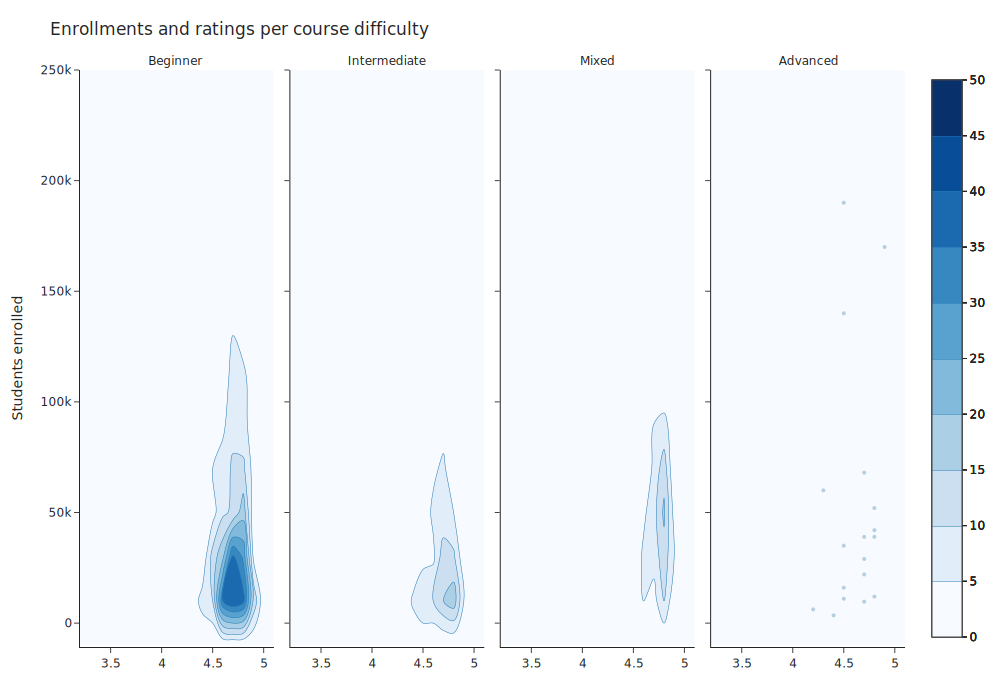

In [125]:
fig = px.density_contour(
    df_cleaned, 
    x="course_rating", 
    y="course_students_enrolled", 
    facet_col="course_difficulty", 
    template="simple_white",
    width=1000, 
    height=700
)

fig.update_traces(
    contours_coloring="fill", 
    colorscale="Blues",
    zmin=0,
    zmax=50,
    hovertemplate=
        "Students Enrolled: %{y:,.0f}<br>" + 
        "Rating: %{x}<br>" + 
        "Density: %{z}<br>" 
)

fig.update_layout(
    title = "Enrollments and ratings per course difficulty",
    yaxis_title = "Students enrolled",
    hoverlabel=dict(
        bgcolor="white",
        bordercolor = "white",
        font=dict(
            color="#494a5e"
        )
    ),
    margin=dict(t=70, b=5)
)

forth_facet_data = df_cleaned[df_cleaned['course_difficulty'] == "Advanced"]
fig.add_trace(go.Scatter(
    x=forth_facet_data['course_rating'],
    y=forth_facet_data['course_students_enrolled'],
    mode='markers',
    marker=dict(
        color="#1D6996",
        size=4,
        opacity=0.3
        ),
        name="Professional certificate",
        hovertext=(
            "Title: " + "<b>" + forth_facet_data["course_title"].astype(str) + "</b>" +"<br>" + 
            "Students Enrolled: " + forth_facet_data["course_students_enrolled"].map(lambda x: f"{x:,.0f}").astype(str) + "<br>" + 
            "Organization: "+ forth_facet_data['course_organization'].astype(str) + "<br>" + 
            "Rating: " + forth_facet_data['course_rating'].astype(str)
        ),  
    hoverinfo="text"
    ), 
    row=1, 
    col=4,
)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_xaxes(title='')

fig.show()

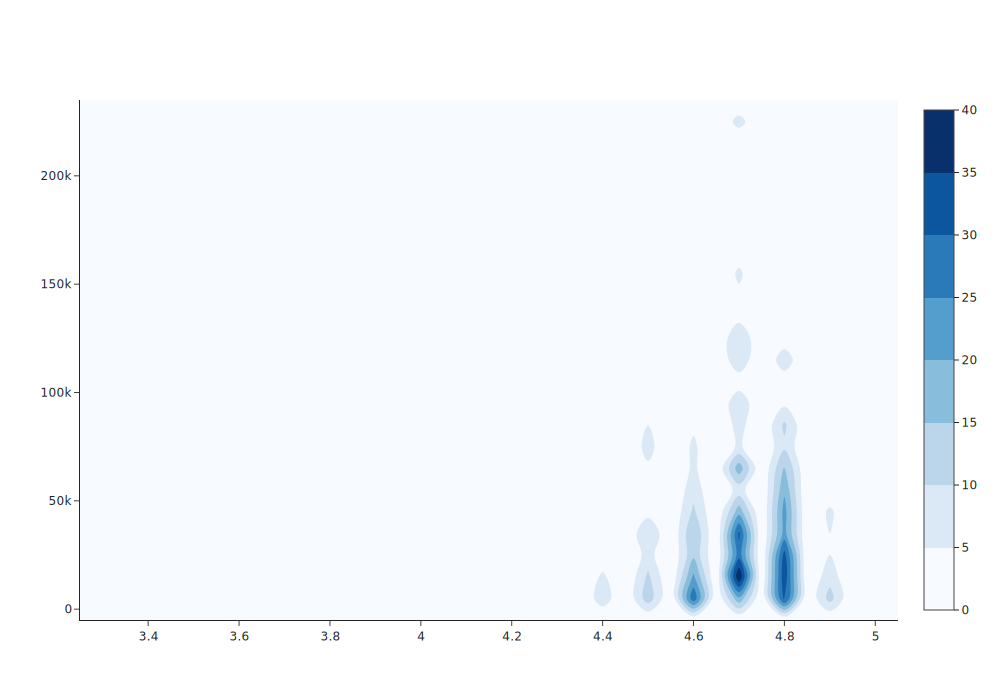

In [126]:
fig = go.Figure()

# Add the contour plot with explicit control over bins
fig.add_trace(go.Histogram2dContour(
    x=df_cleaned['course_rating'],
    y=df_cleaned['course_students_enrolled'],
    colorscale="Blues",
    contours=dict(
        coloring='fill',
        showlines=False  # Disable lines, if you want only filled contours
    ),
    nbinsx=40,  # Number of bins for x-axis (course_rating)
    nbinsy=40   # Number of bins for y-axis (course_students_enrolled)
))

# Add color bar for better visual understanding
fig.update_layout(
    template="simple_white",
    width=1000,
    height=700,
    coloraxis_colorbar=dict(
        title="Density",
        titleside="right"
    )
)

# Show plot
fig.show()